# Method 2: Using TensorFlow MCMC

I'll do this for a single n, and treat the mode locations as fixed for now.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20)


#The stellar parameters are for 16 Cyg A
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
d02 = 6.8 #uHz
dnu = 102. #uHz

In [58]:
locs = np.genfromtxt('locs.txt')
l0 = locs[int(np.floor(len(locs)/2)+1), 0]
l1 = locs[int(np.floor(len(locs)/2)), 1]
l2 = locs[int(np.floor(len(locs)/2)), 2]
l3 = locs[int(np.floor(len(locs)/2)-1), 3]
ff = np.genfromtxt('freqs.txt')
pp = np.genfromtxt('model.txt')

In [59]:
sel = [(ff < l1+.6*dnu) & (ff > l1-2*d02)]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

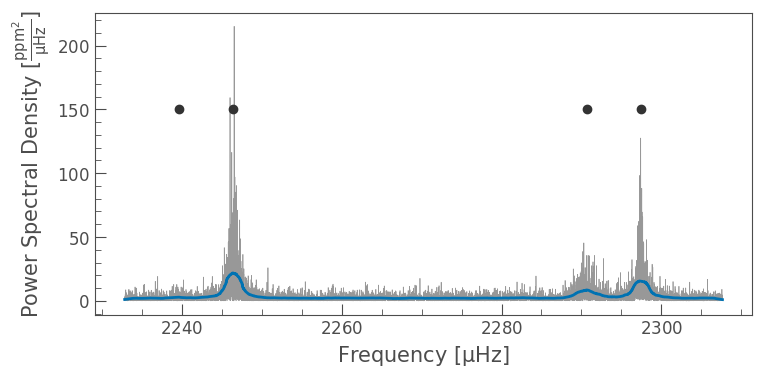

In [60]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter([l0,l1,l2,l3],[150,150,150,150])

I'm going to follow DFM's TF tutorial solutions step by step for an MCMC treatment, and then move on to HMC in a separate notebook.

In [61]:
import tensorflow as tf
print("Using TensorFlow version {0}".format(tf.__version__))

Using TensorFlow version 1.13.1


```python3
params = [vsini, height, width, split (v)]
```

In [62]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
H = 14.
w = 1.
true_params = [np.sin(i)*nus, 14, 1., nus]

In [68]:
T = tf.float64

#Spaces
f_tensor = tf.constant(f, dtype=T)
p_tensor = tf.constant(p, dtype=T)

#Parameters
loc_tensor = tf.Variable([l0,l1,l2,l3], dtype=T)
vsini_tensor = tf.Variable(true_params[0], dtype=T)
H_tensor = tf.Variable(true_params[1], dtype=T)
w_tensor = tf.Variable(true_params[2], dtype=T)
nus_tensor = tf.Variable(true_params[3], dtype=T)

In [69]:
def get_epsilon(i, l, m):
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return tf.math.cos(i)**2
        if np.abs(m) == 1:
            return 0.4 * tf.math.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * tf.math.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*tf.math.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * tf.math.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*tf.math.cos(3*i) + 3*tf.math.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*tf.math.cos(2*i) + 3)**2 * tf.math.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * tf.math.cos(i)**2 * tf.math.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*tf.math.sin(i)**6

def lorentzian(loc, l, m, f, i, H, w, nus):
    height = H * get_epsilon(i, l, m)
    model = height / (1 + (4 / w**2) * (f - loc + m*nus)**2)
    return model
                      
def get_tf_model(f, loc, vsini, H, w, nus):
    i = tf.math.asin(vsini/nus)
    model = tf.ones(tf.shape(f), dtype=T)
    for l in (0, 1, 2, 3):
        for m in range(-l, l+1):
            model += lorentzian(loc[l], l, m, f, i, H, w, nus)
    return model

tfmodel = get_tf_model(f_tensor, loc_tensor, vsini_tensor, H_tensor, w_tensor, nus_tensor)

Now lets try and plot this from a session

In [70]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    model = session.run(tfmodel)

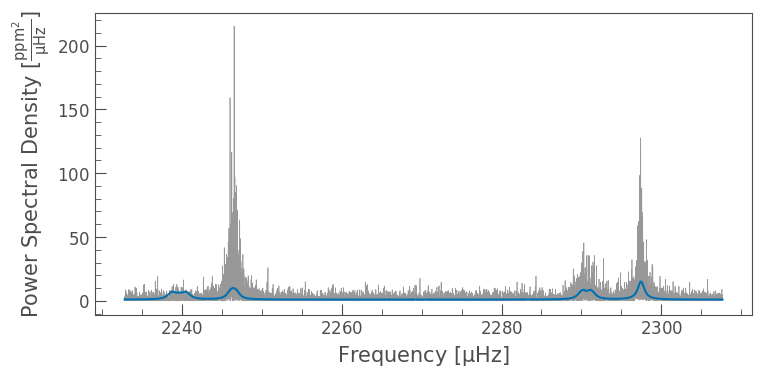

In [71]:
ax = pg.plot(alpha=.5)
plt.plot(pg.frequency, model, label='Tensorflow model')
plt.show()